In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np
from tqdm import tqdm

In [6]:
from __future__ import division

In [8]:
# df = pd.concat( pd.read_csv("LibBldg1") for i in range(1,4) )
df = pd.read_csv("LibBldg1")

In [9]:
df["srcAddr1"], df["srcAddr2"], df["srcAddr3"], df["srcAddr4"] = df["Source"].str.split(".", 3).str
df["destAddr1"], df["destAddr2"], df["destAddr3"], df["destAddr4"] = df["Destination"].str.split(".", 3).str
df = df.drop(["Source", "Destination"], axis=1)
# df = df.drop(["firstSize", "secondSize", "threeSize"], axis=1)

In [10]:
df = df.reset_index()
df = df.drop('index', axis=1)
df

,srcPort,destPort,Protocol,firstSize,secondSize,thirdSize,flowSize,srcAddr1,srcAddr2,srcAddr3,srcAddr4,destAddr1,destAddr2,destAddr3,destAddr4
0,80,3451,TCP,1434,1434,1434,32130,128,17,123,157,190,84,116,78
1,80,3452,TCP,1434,1434,1434,222722,128,17,123,157,190,84,116,78
2,80,3457,TCP,790,694,1434,52550,128,17,123,157,190,84,116,78
3,80,3458,TCP,402,1363,697,74316,128,17,123,157,190,84,116,78
4,80,3505,TCP,194,193,194,39677,128,17,123,157,190,84,116,78
5,80,3507,TCP,194,194,194,103536,128,17,123,157,190,84,116,78
6,80,3510,TCP,195,193,194,10023,128,17,123,157,190,84,116,78
7,80,3512,TCP,195,195,195,1036,128,17,123,157,190,84,116,78
8,1733,1722,TCP,60,60,60,430,128,84,185,150,190,84,116,154
9,80,1129,TCP,1514,1514,1514,7945,128,84,236,31,190,84,117,174


function to convert data to binary to feed to our neural network

In [11]:
# bits: number of bits, n: number to convert
getBits = lambda bits: lambda n: pd.Series(list(('{0:0%db}'%bits).format(int(n))))

In [12]:
protocolMap = {p:i for i,p in enumerate(df.Protocol.unique())}
getProtoBits = lambda p: pd.Series(list(('{0:0%db}'%3).format(protocolMap[p])))

new dataframe for features in binary:

In [13]:
dfb = pd.DataFrame()

In [14]:
SP_cols = ['SP%d'%i for i in range(16)]
dfb[SP_cols] = df['srcPort'].apply(getBits(16))

DP_cols = ['DP%d'%i for i in range(16)]
dfb[DP_cols] = df['destPort'].apply(getBits(16))

for j in range(4):
    SA_cols = ['SA%d'%(i+j*8) for i in range(8)]
    dfb[SA_cols] = df['srcAddr%d'%(j+1)].apply(getBits(8))

for j in range(4):
    DA_cols = ['DA%d'%(i+j*8) for i in range(8)]
    dfb[DA_cols] = df['destAddr%d'%(j+1)].apply(getBits(8))

Pkt1_cols = ['Pkt1-%d'%i for i in range(33)]
dfb[Pkt1_cols] = df['firstSize'].apply(getBits(33))

Pkt2_cols = ['Pkt2-%d'%i for i in range(33)]
dfb[Pkt2_cols] = df['secondSize'].apply(getBits(33))

Pkt3_cols = ['Pkt3-%d'%i for i in range(33)]
dfb[Pkt3_cols] = df['thirdSize'].apply(getBits(33))

Proto_cols = ['Proto-%d'%i for i in range(3)]
dfb[Proto_cols] = df['Protocol'].apply(getProtoBits)

dfb

,SP0,SP1,SP2,SP3,SP4,SP5,SP6,SP7,SP8,SP9,...,Pkt3-26,Pkt3-27,Pkt3-28,Pkt3-29,Pkt3-30,Pkt3-31,Pkt3-32,Proto-0,Proto-1,Proto-2
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,1,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,1,0,0,0
8,0,0,0,0,0,1,1,0,1,1,...,0,1,1,1,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,...,1,1,0,1,0,1,0,0,0,0


### Classifier

convert to matrix

In [192]:
X = dfb.as_matrix()
X[X=='0'] = -1
X[X=='1'] = 1

yr = df["flowSize"]

thres = 1e7
yc = yr.copy(deep=True)
yc[yr > thres] = 1
yc[yr < thres] = -1

In [158]:
sum(yc==-1), sum(yc==1)

(152596, 12)

In [190]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


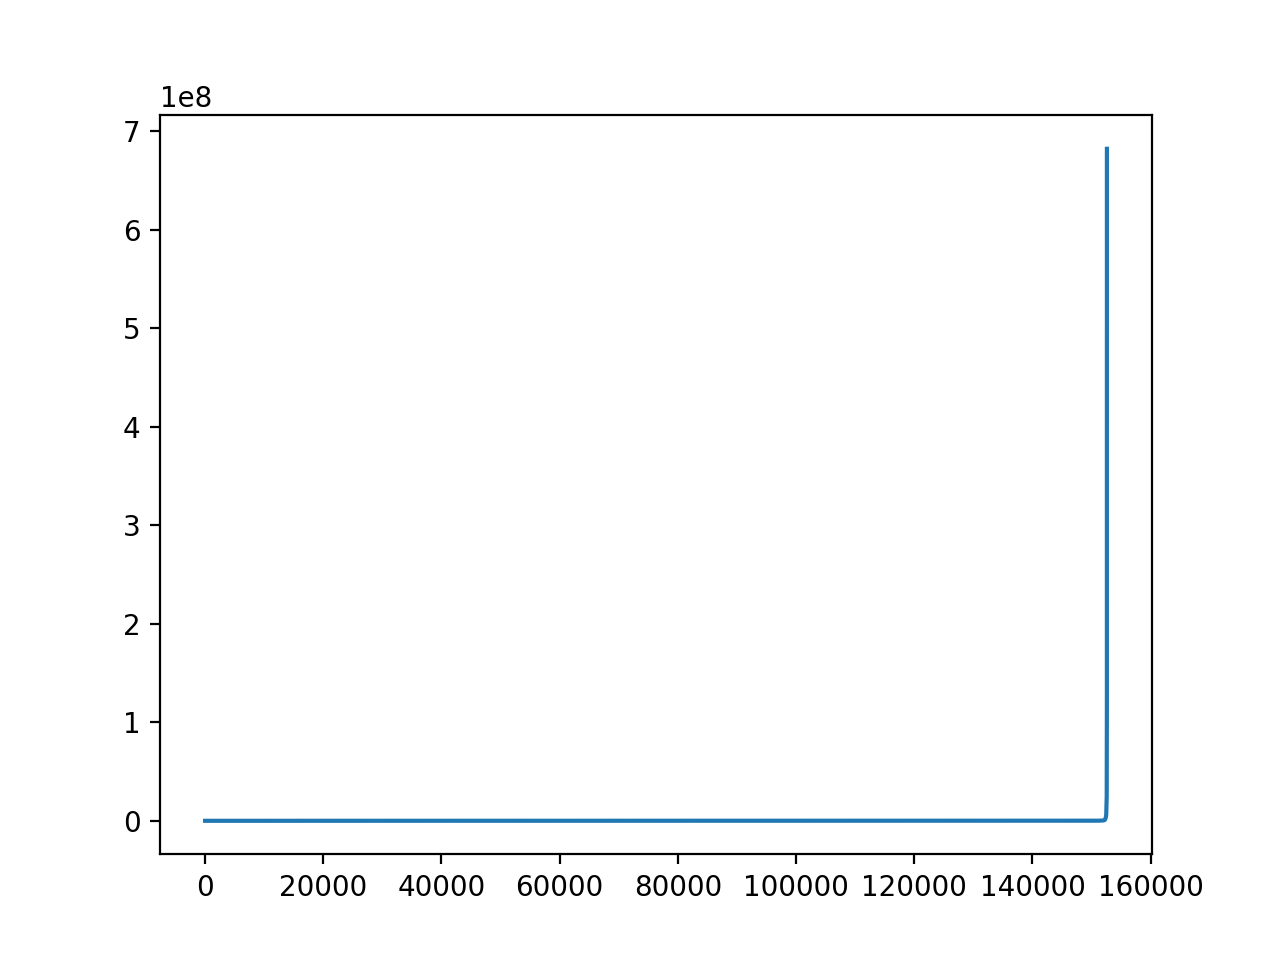

In [191]:
plot(sorted(yr))

#### Test/train split:

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, yc)

In [24]:
# oversampling minority class
while(sum(y_train==-1)/sum(y_train==1) > 2):
    mask = (y_train==1)
    X_train = np.concatenate((X_train, X_train[mask]), axis=0)
    y_train = np.concatenate((y_train, y_train[mask]), axis=0)

In [32]:
sum(y_train==1), sum(y_train==-1), sum(y_test==1), sum(y_test==-1)

(1135, 113321, 399, 37753)

#### neural network:

In [198]:
mlp = MLPClassifier(hidden_layer_sizes=(80, 40), activation='tanh')#, alpha=0.0001)

In [199]:
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)

In [200]:
confusion_matrix(y_test,predictions)

array([[38128,     3],
       [    7,    14]])

In [201]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00     38131
          1       0.82      0.67      0.74        21

avg / total       1.00      1.00      1.00     38152



#### random forest:

In [243]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=15, class_weight='balanced')

In [244]:
rf = rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

In [245]:
confusion_matrix(y_test, predictions)

array([[38129,     2],
       [    8,    13]])

In [246]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00     38131
          1       0.87      0.62      0.72        21

avg / total       1.00      1.00      1.00     38152

